In [ ]:
import pandas as pd
import numpy as np

# Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")  # change if your test file name differs

# Target + features
target = "exam_score"
X = train.drop(columns=[target])
y = train[target]


In [ ]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor


In [ ]:
# --- Updated feature engineering ---
sleep_map = {"poor": 1, "average": 2, "good": 3}
facility_map = {"low": 1, "medium": 2, "high": 3}
difficulty_map = {"easy": 1, "moderate": 2, "hard": 3}

def add_features(df):
    df = df.copy()
    df["age"] = df["age"].astype(str)

    # Ordinal numeric encodings
    df["sleep_quality_num"] = df["sleep_quality"].map(sleep_map)
    df["facility_rating_num"] = df["facility_rating"].map(facility_map)
    df["exam_difficulty_num"] = df["exam_difficulty"].map(difficulty_map)

    # Scaled attendance
    df["attend_pct"] = df["class_attendance"] / 100.0

    # Base composites (refined)
    df["effort_index"] = df["study_hours"] * df["attend_pct"]
    df["sleep_score"] = df["sleep_hours"] * df["sleep_quality_num"]
    df["preparedness"] = df["study_hours"] * df["facility_rating_num"]
    df["effort_vs_difficulty"] = df["study_hours"] / (df["exam_difficulty_num"] + 1)
    df["study_per_sleep"] = df["study_hours"] / (df["sleep_hours"] + 1)

    # Interactions: sleep_score
    df["sleep_score_x_attend"] = df["sleep_score"] * df["attend_pct"]
    df["sleep_score_x_study"] = df["sleep_score"] * df["study_hours"]
    df["sleep_score_x_difficulty"] = df["sleep_score"] * df["exam_difficulty_num"]

    # Interactions: attendance
    df["attendance_x_sleepq"] = df["attend_pct"] * df["sleep_quality_num"]
    df["attendance_x_facility"] = df["attend_pct"] * df["facility_rating_num"]

    # Interactions: study_hours
    df["study_x_difficulty"] = df["study_hours"] * df["exam_difficulty_num"]
    df["study_x_facility"] = df["study_hours"] * df["facility_rating_num"]
    df["study_x_sleepq"] = df["study_hours"] * df["sleep_quality_num"]

    # Interactions: study_method (global effects, not onehot)
    df["method_effort"] = df["study_hours"] * df["attend_pct"]
    df["method_attendance"] = df["attend_pct"]
    df["method_sleep_score"] = df["sleep_score"]

    return df



feature_engineer = FunctionTransformer(add_features, validate=False)


In [ ]:
# Column groups
ordinal_cols = ["sleep_quality", "facility_rating", "exam_difficulty"]
ordinal_categories = [
    ["poor", "average", "good"],
    ["low", "medium", "high"],
    ["easy", "moderate", "hard"]
]

cat_cols = ["study_method", "age"]

num_cols = [
    "study_hours", "class_attendance", "sleep_hours",
    "sleep_quality_num", "facility_rating_num", "exam_difficulty_num",
    "attend_pct",
    "effort_index", "sleep_score", "preparedness",
    "effort_vs_difficulty", "study_per_sleep",
    "sleep_score_x_attend", "sleep_score_x_study", "sleep_score_x_difficulty",
    "attendance_x_sleepq", "attendance_x_facility",
    "study_x_difficulty", "study_x_facility", "study_x_sleepq",
    "method_effort", "method_attendance", "method_sleep_score"
]



preprocess = ColumnTransformer(
    transformers=[
        ("ord", OrdinalEncoder(categories=ordinal_categories), ordinal_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)


In [ ]:
# Best LightGBM model
final_model = LGBMRegressor(
    colsample_bytree=0.8,
    learning_rate=0.03,
    max_depth=8,
    min_child_samples=40,
    n_estimators=800,
    num_leaves=127,
    subsample=0.8,
    random_state=42
)

final_clf = Pipeline(steps=[
    ("feature_engineer", feature_engineer),
    ("preprocess", preprocess),
    ("model", final_model)
])


In [ ]:
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    final_clf, X, y,
    scoring="neg_root_mean_squared_error",
    cv=cv
)

rmse_scores = -scores
rmse_scores, rmse_scores.mean(), rmse_scores.std()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4727
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 39
[LightGBM] [Info] Start training from score 62.482335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4724
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 39
[LightGBM] [Info] Start training from score 62.502155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4724
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 39
[LightGBM] [Info] Start training from score 62.523833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4729
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 39
[LightGBM] [Info] Start training from score 62.522425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4724
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 39
[LightGBM] [Info] Start training from score 62.502613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


(array([8.75217824, 8.75507844, 8.74922672, 8.76863055, 8.78757437]),
 np.float64(8.762537665329903),
 np.float64(0.014171089034612073))

In [ ]:
# Fit on full training data
final_clf.fit(X, y)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4724
[LightGBM] [Info] Number of data points in the train set: 630000, number of used features: 39
[LightGBM] [Info] Start training from score 62.506672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('feature_engineer', ...), ('preprocess', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function add...0020A8F4CFF60>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword argu

In [ ]:
# Predict on test with the latest model
test_preds = final_clf.predict(test)

# Clip + round
test_preds = np.clip(test_preds, 0, 100)
test_preds = np.round(test_preds, 1)

submission = pd.DataFrame({
    "id": test["id"],
    "exam_score": test_preds
})

submission.to_csv("submission4.csv", index=False)
submission.head()



C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,id,exam_score
0,630000,71.7
1,630001,71.0
2,630002,87.7
3,630003,55.4
4,630004,47.7


---

# Creating a model which trains without outliars

In [ ]:
# Define a rule-based filter
filtered_train = train.copy()

mask_outliers = (
    (filtered_train["study_hours"] <= 1) &
    (filtered_train["class_attendance"] <= 50) &
    (filtered_train["exam_score"] >= 95)
)

filtered_train = filtered_train[~mask_outliers]

# Rebuild X, y from filtered data
X_f = filtered_train.drop(columns=["exam_score"])
y_f = filtered_train["exam_score"]


# 8.74(array([8.74559412, 8.75093966, 8.74233621, 8.76064928, 8.77840164]),
 # np.float64(8.755584185393259),
 # np.float64(0.012985941224205521))

# Feature Engineering EDA

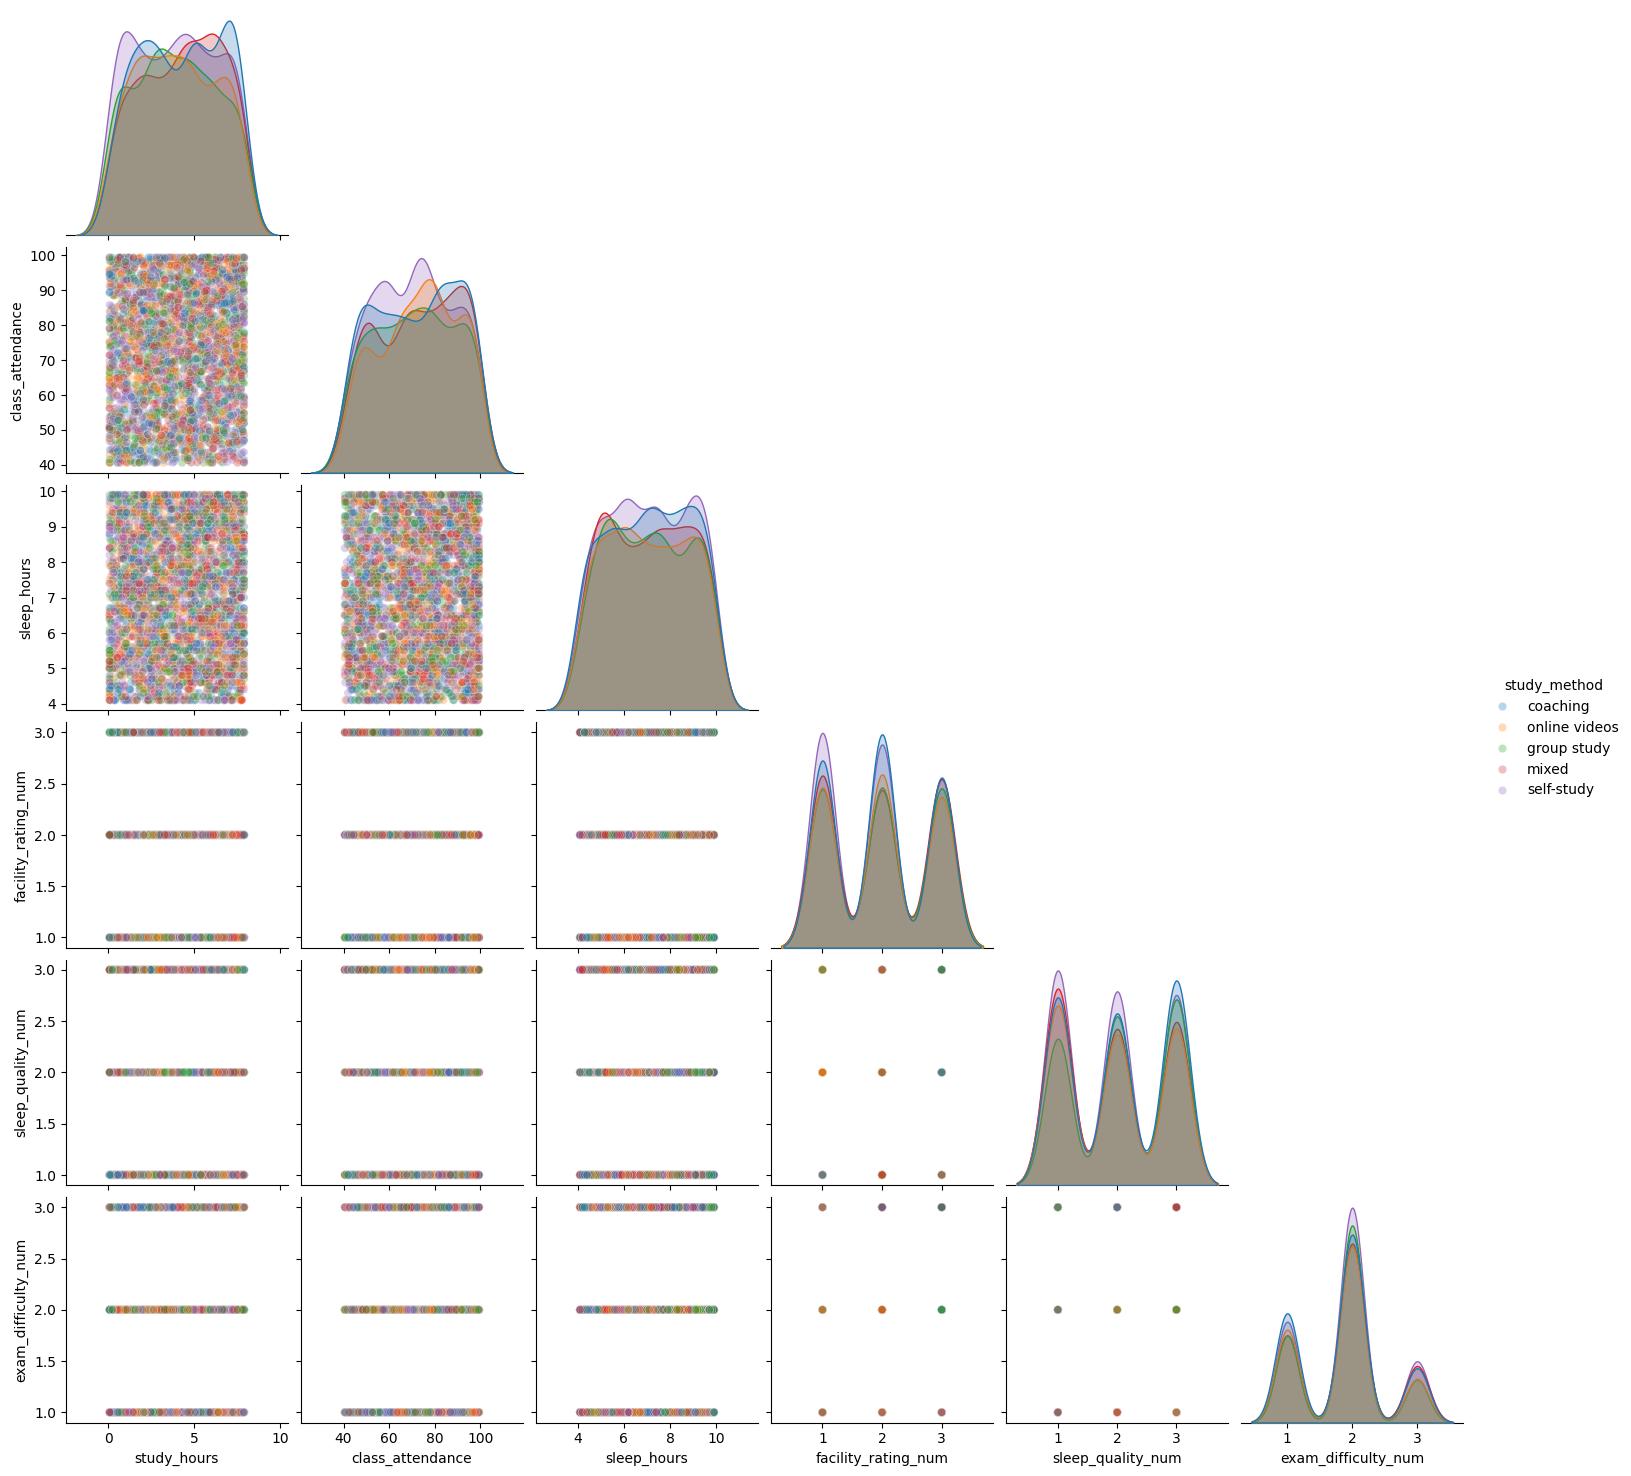

In [ ]:
sample = train.sample(n=3000, random_state=42)
sample = add_features(sample)

num_cols = [
    "study_hours", "class_attendance", "sleep_hours",
    "facility_rating_num", "sleep_quality_num", "exam_difficulty_num"
]

sns.pairplot(sample, vars=num_cols, hue="study_method", corner=True, plot_kws={"alpha":0.3})
plt.show()



KeyboardInterrupt: 

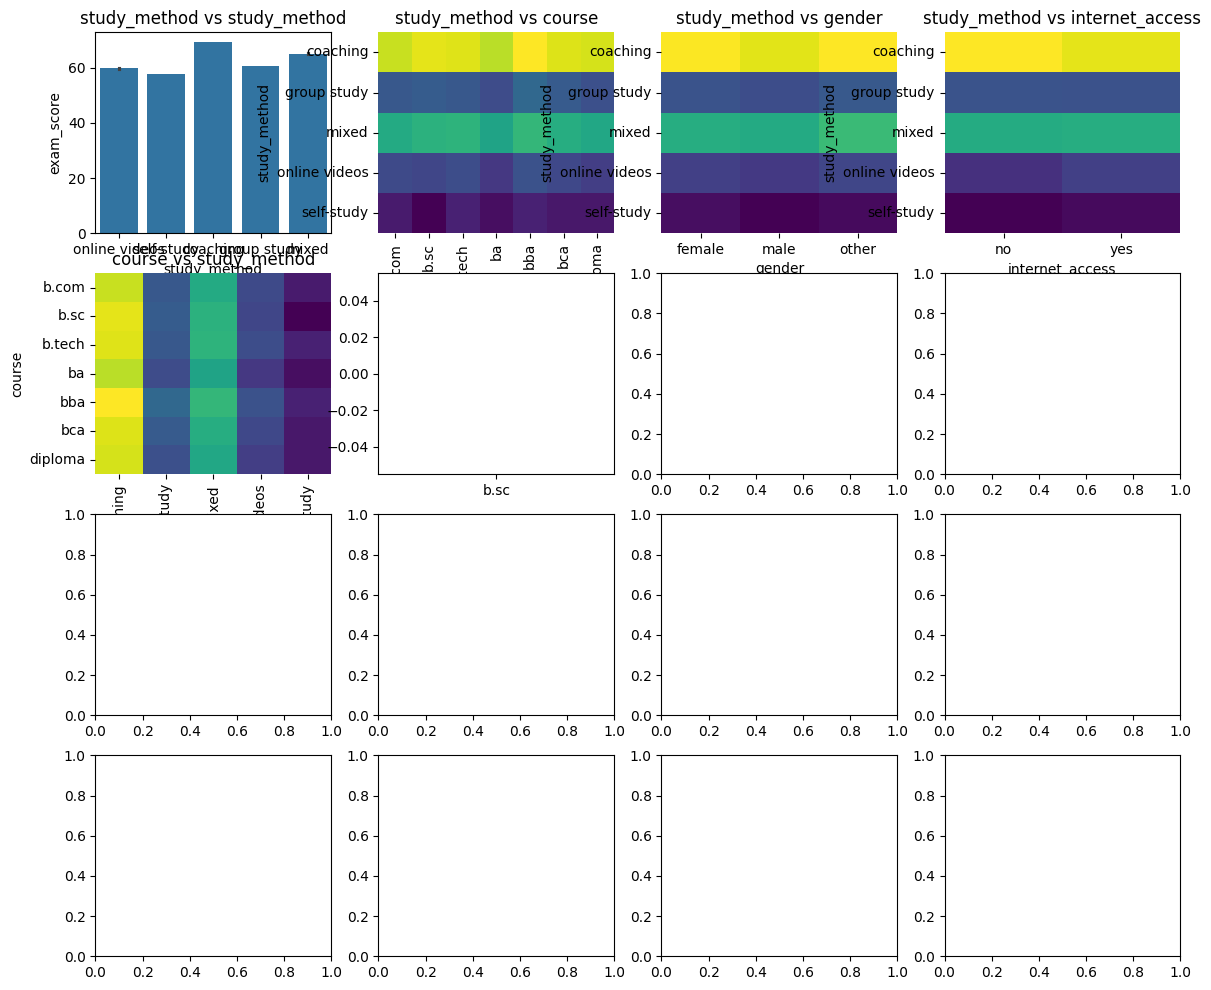

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cats = ["study_method", "course", "gender", "internet_access"]
fig, axes = plt.subplots(len(cats), len(cats), figsize=(14,12))

for i, a in enumerate(cats):
    for j, b in enumerate(cats):
        ax = axes[i, j]
        if i == j:
            sns.barplot(data=train, x=a, y="exam_score", ax=ax)
        else:
            pivot = train.pivot_table(values="exam_score", index=a, columns=b, aggfunc="mean")
            sns.heatmap(pivot, cmap="viridis", ax=ax, cbar=False)
        ax.set_title(f"{a} vs {b}")

plt.tight_layout()
plt.show()


In [ ]:
# Permutation importance (global impact)

from sklearn.inspection import permutation_importance
import pandas as pd

# Fit full pipeline
final_clf.fit(X, y)

# Transform X to expanded feature matrix
X_trans = final_clf.named_steps["preprocess"].transform(
    final_clf.named_steps["feature_engineer"].transform(X)
)

feature_names = final_clf.named_steps["preprocess"].get_feature_names_out()

# Permutation importance on the model using expanded features
result = permutation_importance(
    final_clf.named_steps["model"],
    X_trans, y,
    n_repeats=5,
    random_state=42,
    scoring="neg_root_mean_squared_error"
)

perm = pd.DataFrame({
    "feature": feature_names,
    "importance": result.importances_mean
}).sort_values("importance", ascending=False)

perm.head(20)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 630000, number of used features: 47
[LightGBM] [Info] Start training from score 62.506672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packag

,feature,importance
34,num__effort_index,8.596663
35,num__sleep_score,1.426553
36,num__preparedness,1.060908
13,cat__study_method_coaching,0.895106
29,num__class_attendance,0.730078
28,num__study_hours,0.623449
15,cat__study_method_mixed,0.136922
1,ord__facility_rating,0.135914
30,num__sleep_hours,0.088523
17,cat__study_method_self-study,0.079128


  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
   ---------------------------------------- 0.0/548.0 kB ? eta -:--:--
   ---- ----------------------------------- 61.4/548.0 kB 1.7 MB/s eta 0:00:01
   -------- ------------------------------- 122.9/548.0 kB 1.4 MB/s eta 0:00:01
   ---------------------- ----------------- 307.2/548.0 kB 2.4 MB/s eta 0:00:01
   ------------------------------ --------- 419.8/548.0 kB 2.4 MB/s eta 0:00:01
   ---------------------------------------- 548.0/548.0 kB 2.5 MB/s eta 0:00:00
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   -- ------------------------------------- 0.2/2.7 MB 6.1 MB/s eta 0:00:01
   ---- ----------------------------------- 0.3/2.7 MB 4.9 MB/s eta 0:00:01
   ------- -------------------------------- 0.5/2.7 MB 3.9 MB/s eta 0:00:01
   ---------- ----------------------------- 0.7/2.7 MB 4.2


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\james\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 630000, number of used features: 47
[LightGBM] [Info] Start training from score 62.506672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

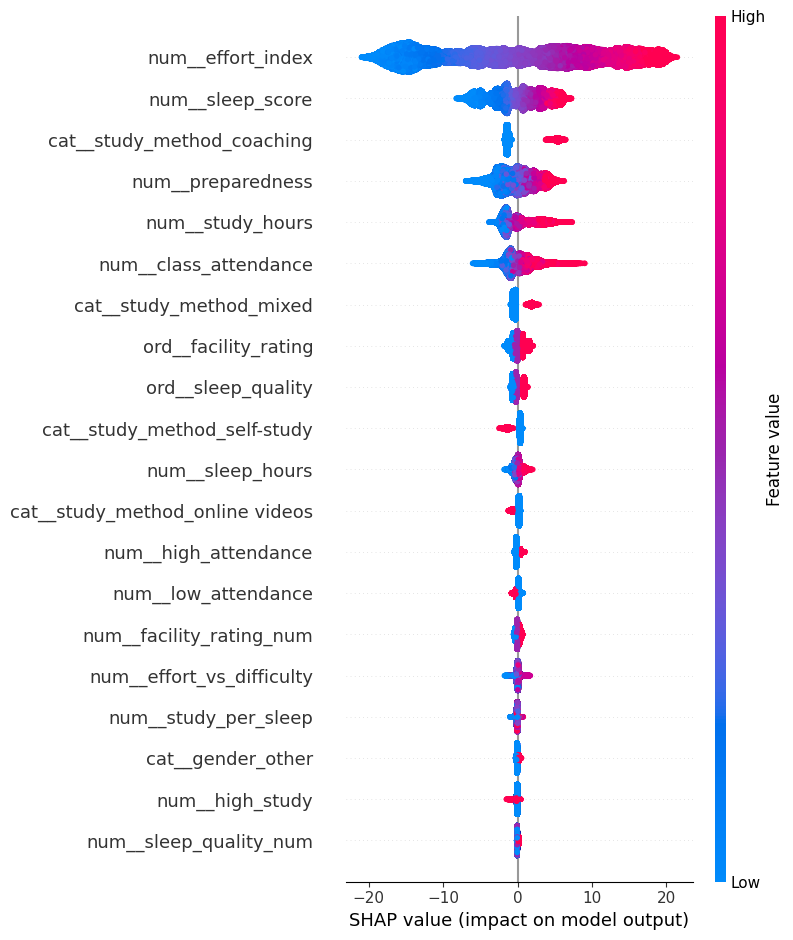

In [ ]:
# SHAP (local + interaction insight)

import shap

# Fit model
final_clf.fit(X, y)

# Transform X through preprocess so SHAP sees numeric matrix
X_trans = final_clf.named_steps["preprocess"].transform(
    final_clf.named_steps["feature_engineer"].transform(X)
)

model = final_clf.named_steps["model"]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_trans)

# Summary plot
shap.summary_plot(shap_values, X_trans, feature_names=final_clf.named_steps["preprocess"].get_feature_names_out())
